# [Data Preprocessing](http://colab.research.google.com/github/boringPpl/presidential_debates_comments_clustering/blob/main/preprocess_data.ipynb)

## 1. Setup

In [1]:
!git clone https://github.com/boringPpl/presidential_debates_comments_clustering.git
%cd presidential_debates_comments_clustering
!pip install -qr requirements.txt

Cloning into 'presidential_debates_comments_clustering'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 94 (delta 39), reused 54 (delta 17), pack-reused 0
Unpacking objects: 100% (94/94), done.
/content/presidential_debates_comments_clustering
     |████████████████████████████████| 133kB 16.9MB/s 
     |████████████████████████████████| 6.4MB 33.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 890kB 53.4MB/s 
     |████████████████████████████████| 1.2MB 52.3MB/s 
     |████████████████████████████████| 3.0MB 53.3MB/s 
     |████████████████████████████████| 890kB 51.7MB/s 


In [2]:
import numpy as np
import pandas as pd
import emoji

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

embedder = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:15<00:00, 25.9MB/s]


## 2. Exploratory Data Analysis

### 2.1 Load data into Pandas

In [3]:
def load_comments(video_id):
    filename = f'data/{video_id}_csv_final.csv'
    df = pd.read_csv(filename, index_col=0)
    return df

In [4]:
df1 = load_comments('bPiofmZGb8o')
comments1 = df1['Comments']
df1['Updated At'] = pd.to_datetime(df1['Updated At'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')

### 2.2 Exploratory data analysis

In [5]:
print(f'The shape of the dataframe is: {df1.shape}')
print(f"The time range for the data is: {df1['Updated At'].min():%Y-%m-%d %H%Mh} to {df1['Updated At'].max():%Y-%m-%d %H%Mh}")
df1.head()

The shape of the dataframe is: (49608, 6)
The time range for the data is: 2020-10-23 0243h to 2021-01-18 0945h


,Comments,Comment ID,Reply Count,Like Count,Updated At,Viewer Rating
0,25:28\nTrump: Did you hear anything?\nBiden: N...,UgxJhAbG8Z-yTkfAPPl4AaABAg,0.0,0,2021-01-18 09:45:30,none
1,53:39 trump the idiot.\nYour the big man! I do...,UgyHNoBZEukz5n3FHgR4AaABAg,0.0,0,2021-01-18 03:57:03,none
2,Trump is the President of the USA ! no biden...,UgzhlTI8JkT8n_sKDuR4AaABAg,0.0,0,2021-01-18 03:36:51,none
3,Driving home from school today because that We...,UgxJmfHfPpwcEdkLFNV4AaABAg,0.0,0,2021-01-18 02:03:25,none
4,Trump won election the swamp rats in Washingto...,UgwZT9ggKbgHu6KbOgN4AaABAg,0.0,0,2021-01-18 00:44:14,none


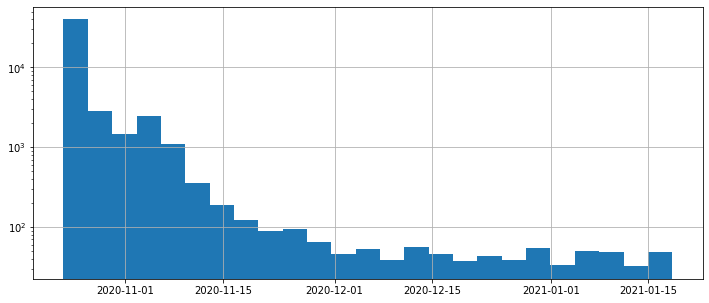

In [6]:
ax = df1['Updated At'].hist(bins=25, figsize=(12, 5))
ax.set_yscale('log')

In [7]:
import emoji
print(emoji.demojize('trending 😉	'))

trending :winking_face:	


In [8]:
df_corpus = df1

In [9]:
df_corpus.rename(columns={'Comments': 'comment_text'}, inplace=True)

In [10]:
# De-emojize
df_corpus['comments_cleaned'] = df_corpus['comment_text'].apply(emoji.demojize)

# Replace the colons, and \n with a space
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.replace('[\n:]', ' ', regex=True)
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.replace(r'\\n', ' ', regex=True)

In [11]:
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.lower()

In [12]:
df_corpus.drop_duplicates(subset=['comments_cleaned'], inplace = True)
df_corpus.shape

(47184, 7)

In [13]:
# remove special characters
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.replace('[^a-zA-Z0-9]', ' ')

# remove white spaces
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.replace('\s+', ' ', regex=True)
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.strip()

In [14]:
df_corpus['comments_cleaned'].to_csv('meta.tsv', columns=['comments_cleaned'], index= False, header= False)

The longest comment has 2993 characters

In [15]:
df_corpus['comments_cleaned'].apply(len).sort_values(ascending=False).head(20)

13649    9649
8742     9572
14669    9357
39329    8032
18645    7502
13222    7429
4739     7033
48888    6823
17436    6714
26363    6246
30068    6076
19148    5943
9159     5886
46668    5758
4851     5732
15616    5653
5239     5653
3757     5540
29311    5498
13054    5313
Name: comments_cleaned, dtype: int64

## Sentence Bert Embeddings

In [16]:
corpus_embeddings = embedder.encode(df_corpus["comments_cleaned"].values.tolist())

In [17]:
corpus_embeddings = np.array(corpus_embeddings)
corpus_embeddings.shape

(47184, 768)

In [18]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, corpus_embeddings, 90)

## Google Universal Encoder

In [19]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/5'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder-large/5, Total size: 577.10MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/5'.


module https://tfhub.dev/google/universal-sentence-encoder-large/5 loaded


In [20]:
#@title Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the emtbedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [-0.0345856137573719, -0.017990121617913246, 0.0019805720075964928, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.05833390727639198, -0.0818500965833664, 0.06890934705734253, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the emtbedding will be.
Embedding size: 512
Embedding: [-0.018883462995290756, -0.0031109179835766554, -0.03367338702082634, ...]



## Semantic Textual Similarity Task Example

The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of two sentences can be trivially computed as the inner product of the encodings.

In [21]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

In [22]:
messages0 = df_corpus["comments_cleaned"].values.tolist()

In [23]:
df_corpus["comments_cleaned"].apply(len).max()

9649

In [ ]:
!nvidia-smi

In [25]:
# embeddings_long = embed([df_corpus['comments_cleaned'].loc[617593]])

In [33]:
# [USComments.csv] Take only the first 2200 characters of each comment. Crashes at 2300+
# [Presidential Debate 1] < 2200. Trying 2000 [Nope]. Trying 1800 [Nope].
# Trying 1000 [Nope]. Trying 500.
max_chars = 500
messages = df_corpus["comments_cleaned"].apply(
    lambda x: x[:max_chars]
).values.tolist()

In [ ]:
embeddings = embed(messages)
np.savetxt('vecs.tsv', embeddings , delimiter="\t")

In [ ]:
pd.Series(messages).apply(len).max()

### PCA reduction

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
#scale the data 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
rescaled = scaler.fit_transform(embeddings)

In [ ]:
pca = PCA().fit(rescaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
# need around 200 components to describe 100% of variance
pca = PCA(n_components = 50)
reduced_embeds = pca.fit_transform(rescaled)
print("Original shape:   ", rescaled.shape)
print("Transformed shape:", reduced_embeds.shape)

In [ ]:
# pca = PCA(n_components = 50)
# reduced_embeds = pca.fit_transform(rescaled)
# reduced_embeds.shape

## Run HDBScan to find the clusters

In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN()
clusterer.fit(reduced_embeds)
clusterer.labels_

In [ ]:
clusterer.labels_.max()

In [ ]:
df_corpus['hdb_labels'] = clusterer.labels_

In [ ]:
df_corpus.to_csv('meta_lab.tsv', columns=['comments_cleaned','hdb_labels'], index= False, header= True, sep='\t')

In [ ]:
!head -5 meta.tsv

In [ ]:
!head -5 meta_lab.tsv

Save`vecs.tsv` and `meta_lab.tsv` and load them into http://projector.tensorflow.org/ (use `vecs.tsv` for Step 1 and `meta_lab.tsv` for step 2)

In [ ]:
from google.colab import files

files.download('vecs.tsv')
files.download('meta_lab.tsv')